# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

np.random.seed(3)

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability 
*   delayed healing 
*   partial paresis 
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\]. 

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-09-11 18:07:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.1’

diabetes_data_uploa 100%[===================>]  33.87K  --.-KB/s    in 0.07s   

2022-09-11 18:07:21 (518 KB/s) - ‘diabetes_data_upload.csv.1’ saved [34682/34682]



In [ ]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [ ]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [ ]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [ ]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20. 
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [ ]:
class Linear:
    # W: weight matrix (in x out)
    # b: bias (out x 1)
    
    #Constructor - we define the parameters of this layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      #The parameters are initialized randomly - uniform distribution [0,1)
      np.random.seed(3)
      self.W = np.random.rand(num_inputs, num_outputs)
      self.b = np.zeros((num_outputs, 1))
      self.lr = learning_rate
      self.name = name
    
    # input: mini-batch (batch_size x in)
    # This function only operates the linear function
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T
    
    # dy: Error in next layer (batch_size x out)
    # This functions receives the error of the next layer and computes the error in this layer
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)
       
      #SGD Rules = update parameters
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db
        
      #The function computes the error in this layer and returns it for backpropagation
      return dx

#Class for the sigmoid activation function
class Sigmoid:
    def __init__(self):
      pass
    
    #Computes the sigmoid function
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output
    
    #Backpropagates the incoming error using the derivative of sigmoid
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4

class ReLU:
  def __init__(self):
    pass
  
  def forward(self, input):
    self.input = input
    ret = input.copy()
    ret[ret<0] = 0
    return ret
  
  def backward(self, dy):
    dx = dy.copy()
    dx[self.input<0] = 0
    return dx

#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)


In [ ]:
#Class for the neural network
class NetworkReLU():
    def __init__(self, learning_rate):
      self.lr = learning_rate #Learning rate
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=16, num_outputs=10, learning_rate=self.lr, name='fc1')) 
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=10, num_outputs=5, learning_rate=self.lr, name='fc2'))
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=self.lr, name='fc3'))
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
      
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
      
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one 
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]
            
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

net = NetworkReLU(0.01)
history = net.train(X_train, Y_train, 20, 2700, X_test, Y_test)
print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))


Epoch 0/2700: loss = 0.1666567029516945: Test accuracy=61.53846153846154
Epoch 20/2700: loss = 0.15472999263904116: Test accuracy=61.53846153846154
Epoch 40/2700: loss = 0.13515304582420914: Test accuracy=61.53846153846154
Epoch 60/2700: loss = 0.11747740139936405: Test accuracy=61.53846153846154
Epoch 80/2700: loss = 0.11281592028337722: Test accuracy=61.53846153846154
Epoch 100/2700: loss = 0.11231953679027117: Test accuracy=61.53846153846154
Epoch 120/2700: loss = 0.11213748422736287: Test accuracy=61.53846153846154
Epoch 140/2700: loss = 0.11193124084571307: Test accuracy=61.53846153846154
Epoch 160/2700: loss = 0.1117063723473011: Test accuracy=61.53846153846154
Epoch 180/2700: loss = 0.11147175924912905: Test accuracy=61.53846153846154
Epoch 200/2700: loss = 0.11123021031833794: Test accuracy=61.53846153846154
Epoch 220/2700: loss = 0.11098254566258911: Test accuracy=61.53846153846154
Epoch 240/2700: loss = 0.11073063897916537: Test accuracy=61.53846153846154
Epoch 260/2700: loss

Para este experimento se decidió hacer una implementación de perceptrón multicapa en numpy, que contiene 4 clases principales: 

*   Clase Linear: representa operaciones lineares en las neuronas.
*   Clase Sigmoid: representa la función sigmoide.
*   Clase ReLU: representa función ReLU.
*   Clase NetworkReLU: utilizada para la construcción, entrenamiento y evaluación de una red neuronal.

Una vez construídas nuestras clases, se puede empezar a probar distintas arquitecturas, siempre respetando el número de neuronas que debe tener la entrada y la salida. Para nuestro caso son 16 entradas (variables con una influencia sobre nuestra clase de salida) y 1 salida (solo queremos predecir 1 variable). En esta experiencia se usó una semilla para la inicialización aleatoria de pesos con el objetivo de poder replicar los experimentos y ajustar los hiperparámetros de forma correcta sin obtener cambios entre una prueba y otra y otro debido a iniciaciones diferentes. Para este experimento, se jugó con el número de hidden layers, el número de neuronas de cada layer y la función de activación utilizada entre cada layer y el número de iteraciones de cada entrenamiento, siempre respetando el uso de la función sigmoide como activación para la última capa. Estas fueron las redes que se probaron:

* 2 hidden layers, con la estructura siguiente en número de neuronas y función de activación: 16 - ReLU - 10 - ReLU - 5 - Sigmoid - 1. Se hizo un entrenamiento con 2000 iteraciones en el que se observó la tendencia a caer en un mínimo local de 92% de test accuracy. A pesar de aumentar considerablemente el número de iteraciones, el algoritmo no logró salir de este mínimo.
* 3 hidden layers, con la estructura siguiente: 16 - ReLU - 12 - ReLU - 8 - ReLu - 4 - Sigmoid - 1. Nuevamente la optimización caía en un mínimo local de 73% de test accuracy que no mejoró con más iteraciónes.
* 2 hidden layers, con la estructura siguiente: 16 - ReLU - 10 - Sigmoid - 5 - Sigmoid - 1. Luego de variar el número de iteraciones, se encontró que con 2700 épocas la red obtenía una test accuracy de 94%.

El proceso de experimentación se realizó según el siguiente razonamiento: en primer lugar se definió una red "baseline" a partir de la que se probó que efectivamente la optimización convergía y la red aprendía. Luego para aumentar la test accuracy se intentó variar en primer lugar el número de iteraciones, solo aumentandolas debido a que se veía en el historial de entrenamiento que con un menor número de épocas, la test accuracy no era mejor. Luego de aumentar considerablemente este hiperparámetro, se observó que el algoritmo tenía una fuerte tendencia a caer en el mismo mínimo local, por lo que se decidió cambiar la arquitectura de la red.

La nueva red se diseñó con un hidden layer más que la red anterior y una disminución proporcional de neuronas entre cada layer. Al probar con diferentes números de iteraciones se observó que esta red no lograba superar el 73% de test accuracy, por lo que claramente había que volver a la arquitectura anterior con nuevas modificaciones.

Finalmente, para la última red neuronal se pensó que como no era muy profunda (tenía solo 2 hidden layers) tal vez el error se propagaría suficientemente bien cambiando una de las funciones de activación, es por esto que solo se implementó una ReLU entre las dos primeras capas y luego para el resto se usó la función sigmoide. Variando el número de iteraciones y viendo el comportamiento de la red se obtuvo que con 2700 iteraciones se obtenía el 94% de test accuracy deseado.

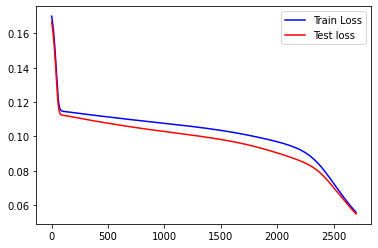

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

El gráfico de la loss muestra cómo el algoritmo va convergiendo, en rojo la loss de validación y en azul la validación de entrenamiento, se observa que ambas siguen casi la misma forma lo que nos da una pista de una buena convergencia. Se puede remarcar el primer decrecimiento fuerte, luego una estabilización y finalmente otro decrecimiento. Todo esto se ve reflejado en el historial de entrenamiento de la red neuronal expuesto en la sección anterior.

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:
net_mini_batch_1 = NetworkReLU(0.01)
history_mini_batch_1 = net_mini_batch_1.train(X_train, Y_train, 1, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_mini_batch_1.evaluate(X_train, Y_train, 1), net_mini_batch_1.evaluate(X_test, Y_test, 1)))

Epoch 0/2000: loss = 0.1557462753523374: Test accuracy=61.53846153846154
Epoch 20/2000: loss = 0.10860110962419758: Test accuracy=70.1923076923077
Epoch 40/2000: loss = 0.10451614442851818: Test accuracy=73.07692307692308
Epoch 60/2000: loss = 0.10111018898940313: Test accuracy=73.07692307692308
Epoch 80/2000: loss = 0.09714678717038247: Test accuracy=74.03846153846153
Epoch 100/2000: loss = 0.09076804468019418: Test accuracy=74.03846153846153
Epoch 120/2000: loss = 0.07937353641904923: Test accuracy=78.84615384615384
Epoch 140/2000: loss = 0.0507595439258353: Test accuracy=92.3076923076923
Epoch 160/2000: loss = 0.03518257052352535: Test accuracy=91.34615384615384
Epoch 180/2000: loss = 0.03167388004908272: Test accuracy=92.3076923076923
Epoch 200/2000: loss = 0.03137772590331883: Test accuracy=91.34615384615384
Epoch 220/2000: loss = 0.032748972977850954: Test accuracy=91.34615384615384
Epoch 240/2000: loss = 0.0329413418552236: Test accuracy=92.3076923076923
Epoch 260/2000: loss = 0

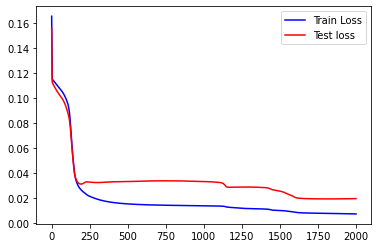

In [ ]:
plt.figure()
plt.plot(history_mini_batch_1['train_loss'], color='b', label='Train Loss')
plt.plot(history_mini_batch_1['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net_mini_batch_5 = NetworkReLU(0.01)
history_mini_batch_5 = net_mini_batch_5.train(X_train, Y_train, 5, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_mini_batch_5.evaluate(X_train, Y_train, 5), net_mini_batch_5.evaluate(X_test, Y_test, 5)))

Epoch 0/2000: loss = 0.16530239432781768: Test accuracy=61.53846153846154
Epoch 20/2000: loss = 0.11273675323191383: Test accuracy=61.53846153846154
Epoch 40/2000: loss = 0.11167577312582355: Test accuracy=61.53846153846154
Epoch 60/2000: loss = 0.1107075037536534: Test accuracy=61.53846153846154
Epoch 80/2000: loss = 0.10970791903611274: Test accuracy=61.53846153846154
Epoch 100/2000: loss = 0.10880336070040338: Test accuracy=70.1923076923077
Epoch 120/2000: loss = 0.10793198816221813: Test accuracy=73.07692307692308
Epoch 140/2000: loss = 0.107066276314482: Test accuracy=73.07692307692308
Epoch 160/2000: loss = 0.10624309698626319: Test accuracy=73.07692307692308
Epoch 180/2000: loss = 0.10545225793032609: Test accuracy=73.07692307692308
Epoch 200/2000: loss = 0.10469382565275742: Test accuracy=73.07692307692308
Epoch 220/2000: loss = 0.10398966646235953: Test accuracy=73.07692307692308
Epoch 240/2000: loss = 0.10330249322927625: Test accuracy=73.07692307692308
Epoch 260/2000: loss =

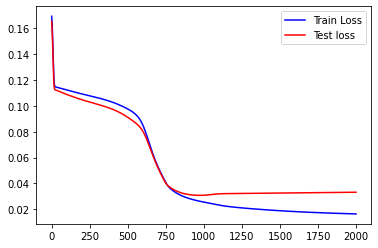

In [ ]:
plt.figure()
plt.plot(history_mini_batch_5['train_loss'], color='b', label='Train Loss')
plt.plot(history_mini_batch_5['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net_mini_batch_50 = NetworkReLU(0.01)
history_mini_batch_50 = net_mini_batch_50.train(X_train, Y_train, 50, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_mini_batch_50.evaluate(X_train, Y_train, 50), net_mini_batch_50.evaluate(X_test, Y_test, 50)))

Epoch 0/2000: loss = 0.16690444970420357: Test accuracy=61.53846153846154
Epoch 20/2000: loss = 0.16261954712020726: Test accuracy=61.53846153846154
Epoch 40/2000: loss = 0.15710530560357686: Test accuracy=61.53846153846154
Epoch 60/2000: loss = 0.15005626892888235: Test accuracy=61.53846153846154
Epoch 80/2000: loss = 0.1413977296074946: Test accuracy=61.53846153846154
Epoch 100/2000: loss = 0.13180911539301873: Test accuracy=61.53846153846154
Epoch 120/2000: loss = 0.12307647472694544: Test accuracy=61.53846153846154
Epoch 140/2000: loss = 0.11708415007954666: Test accuracy=61.53846153846154
Epoch 160/2000: loss = 0.11405793501104024: Test accuracy=61.53846153846154
Epoch 180/2000: loss = 0.11288698295086191: Test accuracy=61.53846153846154
Epoch 200/2000: loss = 0.11251432781041835: Test accuracy=61.53846153846154
Epoch 220/2000: loss = 0.11240014543723384: Test accuracy=61.53846153846154
Epoch 240/2000: loss = 0.1123442141748012: Test accuracy=61.53846153846154
Epoch 260/2000: loss

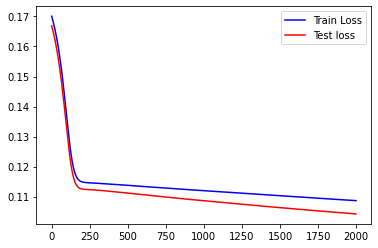

In [ ]:
plt.figure()
plt.plot(history_mini_batch_50['train_loss'], color='b', label='Train Loss')
plt.plot(history_mini_batch_50['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net_mini_batch_n = NetworkReLU(0.01)
history_mini_batch_n = net_mini_batch_n.train(X_train, Y_train, 415, 57000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_mini_batch_n.evaluate(X_train, Y_train, 415), net_mini_batch_n.evaluate(X_test, Y_test, 415)))

Epoch 0/57000: loss = 0.1670716730213347: Test accuracy=61.53846153846154
Epoch 20/57000: loss = 0.16665777711266808: Test accuracy=61.53846153846154
Epoch 40/57000: loss = 0.166232691431898: Test accuracy=61.53846153846154
Epoch 60/57000: loss = 0.16579605380436999: Test accuracy=61.53846153846154
Epoch 80/57000: loss = 0.16534749253480932: Test accuracy=61.53846153846154
Epoch 100/57000: loss = 0.1648866267181447: Test accuracy=61.53846153846154
Epoch 120/57000: loss = 0.16441306665988736: Test accuracy=61.53846153846154
Epoch 140/57000: loss = 0.1639264144226297: Test accuracy=61.53846153846154
Epoch 160/57000: loss = 0.16342626451715464: Test accuracy=61.53846153846154
Epoch 180/57000: loss = 0.16291220475872134: Test accuracy=61.53846153846154
Epoch 200/57000: loss = 0.16238381731130172: Test accuracy=61.53846153846154
Epoch 220/57000: loss = 0.16184067994487483: Test accuracy=61.53846153846154
Epoch 240/57000: loss = 0.16128236753331335: Test accuracy=61.53846153846154
Epoch 260/

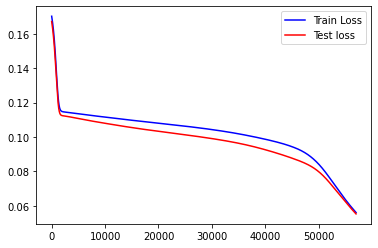

In [ ]:
plt.figure()
plt.plot(history_mini_batch_n['train_loss'], color='b', label='Train Loss')
plt.plot(history_mini_batch_n['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

Conclusiones:



*   Cuando se usan mini-batches pequeños, cada iteración tarda más tiempo que cuando se aumenta el número de elementos del mini-batch. Esto se pude explicar por el paralelismo que se implementa dentro de cada mini-batch. En el caso extremo de m=1, se observa que cada época toma mucho más tiempo debido a que se procesa solo un elemento a la vez y por cada uno se calcula un nuevo gradiente. Por el contrario, cuando aumentamos el tamaño de los mini-batches, vemos que cada iteración es mucho más rapida debido a que entran más muestras que se procesan en paralelo.
*   En cuanto a la accuracy de cada uno de los experimentos, se puede remarcar que cuando el mini-batch es de tamaño 1, tanto la train, como la test accuracy es elevada. Además de ser mayor el resultado final, se observa que rápidamente se obtiene un buen mínimo, con 1600 iteraciones ya alcanzamos un 95% de test accuracy. Pero este mínimo no es muy estable, debido a que con un par de iteraciones más, la optimización sale de ahí y encuentra un resultado peor, esto se puede explicar debido a los cambios abruptos que puede tomar el gradiente entre una muestra y otra. Por el contrario, a medida que se aumenta el número de muestras por mini-batch, se observa que la red va aprendiendo con mayor "seguridad" o certeza, pero requiere más épocas para aprender. Es como si diera pasos más pequeños pero con mayor confianza. Por ejemplo, cuando m=50, el resultado luego de 2000 iteraciones es solamente 73%, si aumentamos el número de iteraciones se ve una tendencia a aumentar la accuracy tanto de test, como de train pero toma bastantes épocas. El resultado toma todavía más iteraciones cuando aumentamos el tamaño del mini-batch al tamaño del dataset, por más que cada iteración se compute rápidamente, se necesitan 57000 iteraciones para alcanzar un 95% de test accuracy.
*   En cuanto a la forma de converger del algoritmo y la loss function se presentan bastantes diferencias entre la convergencia llevada a cabo con batches pequeños y batches grandes. En el caso de m=1 notamos que la loss function inicia con un gran descenso y luego queda "estancada" en torno a los mismos valores y presenta bastante ruido. Cabe destacar que con batches más pequeños obtenemos una loss que converge a valores más pequeños que la loss function de la parte 1, esto se puede atribuír a que la loss se calcula con solo pocos elementos a la vez (en casos de pequeños minibatches). A medida que vamos aumentando el tamaño de los batches vemos que el decrecimiento de la loss funcion se va haciendo más suave y que en general termina con una pendiente pronunciada que podría decirnos que existe potencialmente un mínimo más óptimo. La loss function expuesta en el caso de m=n presenta la misma forma y termina en los mismos valores que la loss fucntion obtenida en la parte 1, con la diferencia de que requiere muchas más iteraciones. Probablemente la justificación de todo esto es que el gradiente usado para este tipo de entrenamiento considera todas las muestras y por lo tanto toma un camino más "lento" pero siempre mirando toda la data disponible.





# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:
net_05 = NetworkReLU(0.5)
history_net_05 = net_05.train(X_train, Y_train, 20, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_05.evaluate(X_train, Y_train, 20), net_05.evaluate(X_test, Y_test, 20)))

Epoch 0/2000: loss = 0.12629748762255188: Test accuracy=61.53846153846154
Epoch 20/2000: loss = 0.10247022997280836: Test accuracy=73.07692307692308
Epoch 40/2000: loss = 0.08940025524128181: Test accuracy=74.03846153846153
Epoch 60/2000: loss = 0.03685662206490679: Test accuracy=91.34615384615384
Epoch 80/2000: loss = 0.032893867174095384: Test accuracy=91.34615384615384
Epoch 100/2000: loss = 0.0351976332881267: Test accuracy=91.34615384615384
Epoch 120/2000: loss = 0.03387879793982597: Test accuracy=92.3076923076923
Epoch 140/2000: loss = 0.033551469426094715: Test accuracy=93.26923076923077
Epoch 160/2000: loss = 0.03376801676676765: Test accuracy=93.26923076923077
Epoch 180/2000: loss = 0.033743471079486206: Test accuracy=93.26923076923077
Epoch 200/2000: loss = 0.03374252746853089: Test accuracy=92.3076923076923
Epoch 220/2000: loss = 0.03384107195467529: Test accuracy=92.3076923076923
Epoch 240/2000: loss = 0.033955970226537645: Test accuracy=92.3076923076923
Epoch 260/2000: los

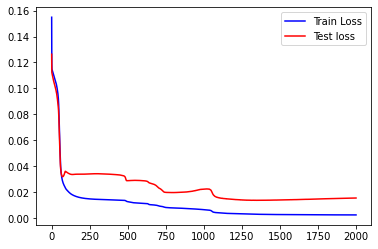

In [ ]:
plt.figure()
plt.plot(history_net_05['train_loss'], color='b', label='Train Loss')
plt.plot(history_net_05['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net_0005 = NetworkReLU(0.005)
history_net_0005 = net_0005.train(X_train, Y_train, 20, 2000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_0005.evaluate(X_train, Y_train, 20), net_0005.evaluate(X_test, Y_test, 20)))

Epoch 0/2000: loss = 0.16687587608803073: Test accuracy=61.53846153846154
Epoch 20/2000: loss = 0.1618378947835114: Test accuracy=61.53846153846154
Epoch 40/2000: loss = 0.1551155095510804: Test accuracy=61.53846153846154
Epoch 60/2000: loss = 0.14631133449099418: Test accuracy=61.53846153846154
Epoch 80/2000: loss = 0.13569718121624022: Test accuracy=61.53846153846154
Epoch 100/2000: loss = 0.1251977964421625: Test accuracy=61.53846153846154
Epoch 120/2000: loss = 0.11773908812836936: Test accuracy=61.53846153846154
Epoch 140/2000: loss = 0.11412581853995231: Test accuracy=61.53846153846154
Epoch 160/2000: loss = 0.11284790964589611: Test accuracy=61.53846153846154
Epoch 180/2000: loss = 0.11246231763044424: Test accuracy=61.53846153846154
Epoch 200/2000: loss = 0.11232446055758001: Test accuracy=61.53846153846154
Epoch 220/2000: loss = 0.11223392752199088: Test accuracy=61.53846153846154
Epoch 240/2000: loss = 0.11214249016887658: Test accuracy=61.53846153846154
Epoch 260/2000: loss 

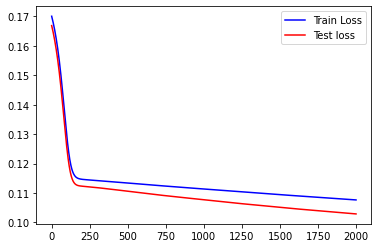

In [ ]:
plt.figure()
plt.plot(history_net_0005['train_loss'], color='b', label='Train Loss')
plt.plot(history_net_0005['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

In [ ]:
net_0000001 = NetworkReLU(0.000001)
history_net_0000001 = net_0000001.train(X_train, Y_train, 20, 10000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net_0000001.evaluate(X_train, Y_train, 20), net_0000001.evaluate(X_test, Y_test, 20)))

Epoch 0/10000: loss = 0.16709203750177648: Test accuracy=61.53846153846154
Epoch 20/10000: loss = 0.16709117853212413: Test accuracy=61.53846153846154
Epoch 40/10000: loss = 0.16709031951445263: Test accuracy=61.53846153846154
Epoch 60/10000: loss = 0.16708946044875866: Test accuracy=61.53846153846154
Epoch 80/10000: loss = 0.1670886013350392: Test accuracy=61.53846153846154
Epoch 100/10000: loss = 0.16708774217329078: Test accuracy=61.53846153846154
Epoch 120/10000: loss = 0.1670868829635103: Test accuracy=61.53846153846154
Epoch 140/10000: loss = 0.1670860237056944: Test accuracy=61.53846153846154
Epoch 160/10000: loss = 0.16708516439983986: Test accuracy=61.53846153846154
Epoch 180/10000: loss = 0.16708430504594343: Test accuracy=61.53846153846154
Epoch 200/10000: loss = 0.16708344564400188: Test accuracy=61.53846153846154
Epoch 220/10000: loss = 0.16708258619401198: Test accuracy=61.53846153846154
Epoch 240/10000: loss = 0.16708172669597038: Test accuracy=61.53846153846154
Epoch 26

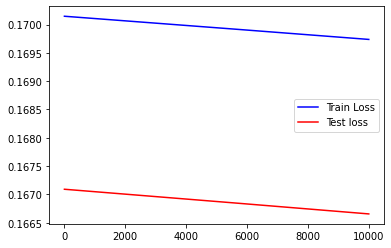

In [ ]:
plt.figure()
plt.plot(history_net_0000001['train_loss'], color='b', label='Train Loss')
plt.plot(history_net_0000001['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

En esta sección se hicieron 3 experimentos variando la learning rate:


1.   Learning rate = 0.5: en este experimento se observa que la red se mueve rápidamente hacia buenos mínimos (con unas pocas iteraciones) pero luego se ve que oscila en torno a los mínimos encontrados. Esto se ve manifestado en el gráfico de la loss funcion donde se puede ver un gran decrecimiento al inicio pero luego unas oscilaciones en torno los valores cercanos a 0.02, sobretodo para la test loss. La forma que presenta la función es bastante distinta a lo obtenido en la parte 1 donde se manifestaba un decrecimiento un poco más por "escalones". 
2.   Learning rate = 0.005: en este experimento se ve que a la red le cuesta un poco más moverse de su accuracy inicial, tarda al rededor de 700 épocas en comenzar a aumentar la accuracy. Una vez terminadas las 2000 iteraciones, notamos que no alcanza los valores de test accuracy obtenidos con otras learning rates, quedando solo en 73%. Esto muestra lo lento que se converge con pequeñas learning rates. En cuanto a la loss function, se observa que es inicialmente descendiente pero luego se estabiliza al rededor de 0.1, similarmente a la loss function obtenida en la parte 1 pero no logra ser menor con 2000 iteraciones.
3.   Learning rate = 0,000001: en esta prueba se observa que la red no logra aprender en lo absoluto. A pesar de entrenarlo con 10000 épocas la accuracy no aumenta (o muy poco) y la loss funcion desciende solamente 0.0005.

Si comparamos estos 3 resultados con lo obtenido en la parte 1 podemos ver que ningún comportamiento se asemeja. La loss function obtenida en la parte 1 mostraba pequeños decrementos y estabilizaciones intermediaras, mientras que en estas experiencias se vio en el primer caso solamente una disminución inicial, muy rápida, en el segundo un primer decremento que quedó estático y en la tercera casi ningún movimiento. Es como si cada parte de los experimentos fuera un "zoom" de las 3 partes principales de la loss function obtenida en la parte 1.



# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:

def generate_batch_indices(index_list, mini_batches, batch_size):
    if len(index_list) <= batch_size:
        mini_batches.append(index_list)
        return mini_batches
    else:
        index_btch = random.sample(index_list, batch_size)
        mini_batches.append(index_btch)
        for element in index_btch:
            index_list.remove(element)
        return generate_batch_indices(index_list, mini_batches)

def generate_data_from_indices(index_list, data):
    mini_batch = []
    for i in index_list:
      element = data[i]
      np.array(mini_batch, element)
    return mini_batch



#Class for the neural network
class NetworkRandomMiniBatch():
    def __init__(self):
      learning_rate = 0.01 #Learning rate
        
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons
      self.layers = [] 
      self.layers.append(Linear(num_inputs=16, num_outputs=10, learning_rate=self.lr, name='fc1')) 
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=10, num_outputs=5, learning_rate=self.lr, name='fc2'))
      self.layers.append(Sigmoid())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=self.lr, name='fc3'))
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)
      
    
    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
        
      
      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch

        loss = 0
      
        index_list = list(range(0, 415, 1))
        mini_batches = generate_batch_indices(index_list, [], batch_size)
        #Iterate over each batch

        for batch_indices in mini_batches:
          
          data = generate_data_from_indices(batch_indices, training_data)
          label = generate_data_from_indices(batch_indices, training_label)
                                
          acc = 0
                
          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output          
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout
                    
        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)
                                  
        #Test after one epoch
        loss = 0
        outputs = []
            
        correct = 0
        for batch_indices in mini_batches:
          
          data = generate_data_from_indices(batch_indices, training_data)
          label = generate_data_from_indices(batch_indices, training_label)
                                
          acc = 0
                
          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output
                
          loss += mse(output, label)
                
          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()
            
        loss /= test_data.shape[0]
        test_loss.append(loss)
            
        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
                    
      return dict({'train_loss': train_loss, 'test_loss':test_loss})
    
    def evaluate(self, data, label, batch_size):
      correct = 0
      index_list = list(range(0, 415, 1))
      mini_batches = generate_batch_indices(index_list, [], batch_size)
      #Iterate over each batch

      for batch_indices in mini_batches:
        
        ndata = generate_data_from_indices(batch_indices, data)
        nlabel = generate_data_from_indices(batch_indices, label)

        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
            
        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()
        
      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
                    
        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output
                    
        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)
      
      return np.vstack(output_pred)

net_random_mini_batch = NetworkReLU(0.01)
history_random_mini_batch = net_random_mini_batch.train(X_train, Y_train, 20, 2700, X_test, Y_test)
print('Train accuracy:{} - Test accuracy: {}'.format(net_random_mini_batch.evaluate(X_train, Y_train, 20), net_random_mini_batch.evaluate(X_test, Y_test, 20)))

Epoch 0/2700: loss = 0.1666567029516945: Test accuracy=61.53846153846154
Epoch 20/2700: loss = 0.15472999263904116: Test accuracy=61.53846153846154
Epoch 40/2700: loss = 0.13515304582420914: Test accuracy=61.53846153846154
Epoch 60/2700: loss = 0.11747740139936405: Test accuracy=61.53846153846154
Epoch 80/2700: loss = 0.11281592028337722: Test accuracy=61.53846153846154
Epoch 100/2700: loss = 0.11231953679027117: Test accuracy=61.53846153846154
Epoch 120/2700: loss = 0.11213748422736287: Test accuracy=61.53846153846154
Epoch 140/2700: loss = 0.11193124084571307: Test accuracy=61.53846153846154
Epoch 160/2700: loss = 0.1117063723473011: Test accuracy=61.53846153846154
Epoch 180/2700: loss = 0.11147175924912905: Test accuracy=61.53846153846154
Epoch 200/2700: loss = 0.11123021031833794: Test accuracy=61.53846153846154
Epoch 220/2700: loss = 0.11098254566258911: Test accuracy=61.53846153846154
Epoch 240/2700: loss = 0.11073063897916537: Test accuracy=61.53846153846154
Epoch 260/2700: loss

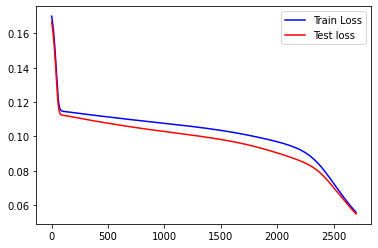

In [ ]:
plt.figure()
plt.plot(history_random_mini_batch['train_loss'], color='b', label='Train Loss')
plt.plot(history_random_mini_batch['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

En esta experiencia se probó la generación aleatoria de mini batches en cada época tanto para el entrenamiento como para la evaluación de la red neuronal. Podemos observar que el entrenamiento no cambia mucho a lo estudiado en la parte 1:
 

*   Se observa que a medida que avanzan las iteraciones, la test accuracy avanza de igual manera si los batches son generados de forma aleatoria o no. En ambos casos, al cabo de 2700 iteraciones, para mini batches de tamaño 20 la test accuracy es de 94.2%.
*   En cuanto a la loss function, observamos que tanto la train como la test loss sigue la misma forma, en este caso y en el de la parte 1. A medida que avanzan las épocas, se siguen los mismos valores y se converge al mismo valor de 0.06, lo que es coherente con el aumento progresivo de la test accuracy en amvos casos.

Conclusiones y discusión:
*   A pesar de entrenar la red con datos generados aleatóriamente, esta sigue el mismo "camino" hacia la convergencia, es decir, pasa por los mismos mínimos locales al mismo "tiempo" (en el mismo número de épocas). Esto se debe a que como el método de gradiente estocástico toma en consideración la misma cantidad de eleméntos para estimar un gradiente representante de todo el conjunto de datos hay tendencia de seguir por el mismo "camino". 
*   Podemos remarcar entonces que el gradiente estocástico es un buen método aproximativo para poder facilitar el entrenamiento debido a que no depende del orden en que se procesen los datos, ni de los subconjuntos generados para el procesamiento sino que solamente de que toda la data sea procesada al momento de la optimización y de la estructura de la red.
*   Esto pone en evidencia tanto la teoría de que el gradiente completo puede ser estimado con gradientes de mini-batches, como la robustez que presenta nuestra red neuronal que no depende del orden en que se procesen los datos.